# Images

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random

Using TensorFlow backend.
/home/dylan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dylan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dylan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dylan/.local/lib/python3.7/site-packages/tensorflow/python/fra

### Read in training/testing ids and depths

In [2]:
train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

### Convert images to numpy arrays

In [3]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/dylan/.local/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

### Calculate salt coverage and salt coverage classes

In [8]:
img_size_ori = 101
img_size_target = 101

In [9]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

### Test train split 

In [11]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.25, stratify=train_df.coverage_class, random_state= 713)

### Looking at images 

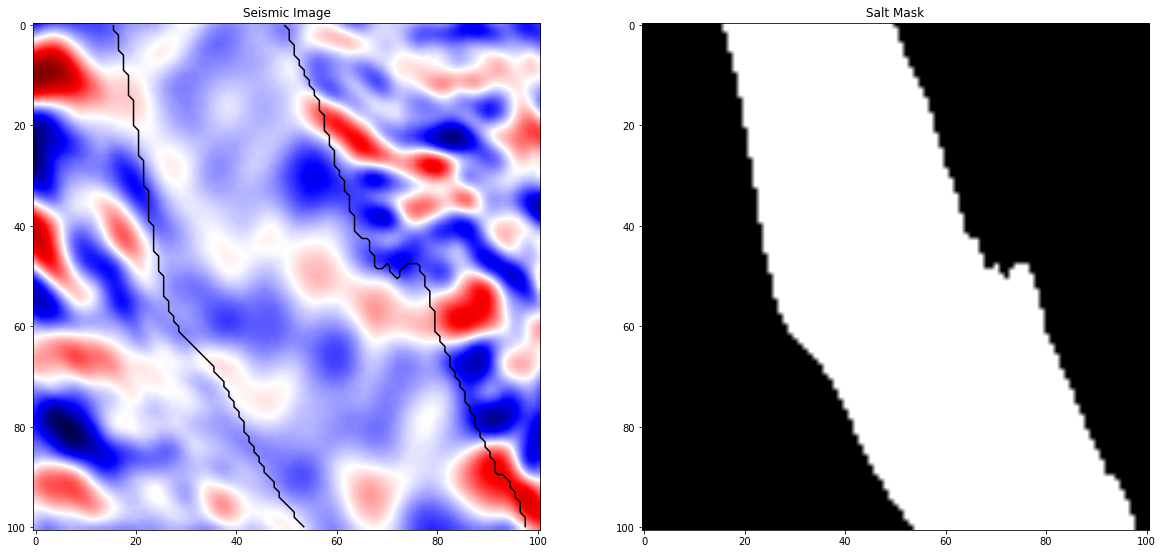

In [24]:
# Check if training data looks all right
ix = random.randint(0, len(x_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(x_train[ix, ..., 0], cmap= 'seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt Mask');

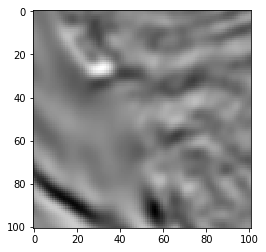

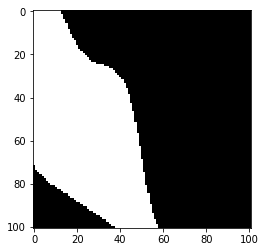

In [13]:
# Check if training data looks all right
ix = random.randint(0, len(x_train))
plt.imshow(np.dstack((x_train[ix],x_train[ix],x_train[ix])))
plt.show()
tmp = np.squeeze(y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()